# Import Module

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn import preprocessing

# Load Data

In [124]:
train = pd.read_csv("train.csv")
daikon = train[train.kind == "だいこん"].sort_values("date").mode_price.values

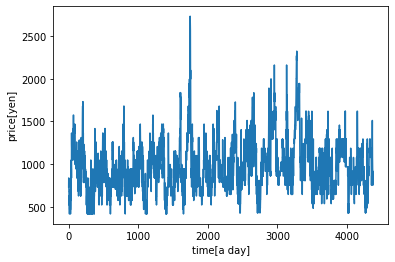

In [125]:
plt.xlabel("time[a day]")
plt.ylabel("price[yen]")
plt.plot(daikon)

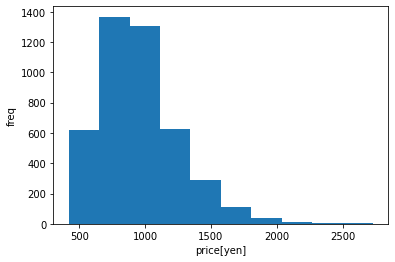

In [126]:
plt.xlabel("price[yen]")
plt.ylabel("freq")
plt.hist(daikon)
plt.show()

# Preprocessing

In [127]:
train_size = 4000
train = daikon[:train_size].reshape(-1, 1)
test = daikon[train_size:].reshape(-1, 1)

ss = preprocessing.StandardScaler()
ss.fit(train)
train = ss.transform(train)
test = ss.transform(test)

T = 10
train_N = train.shape[0] // 10
test_N = test.shape[0] // 10
train = train[:train_N * T]
test = test[:test_N * T]

train = train.reshape(train_N, T, 1)
train_x = train[:, :-1, :]
train_y = train[:, 1:, :]
test = test.reshape(test_N, T, 1)
test_x = test[:, :-1, :]
test_y = test[:, 1:, :]

In [128]:
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

# Build Model

In [129]:
class rnn(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.rnn1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.LSTM(hidden_size, int(hidden_size/2), batch_first=True)
        self.fc = nn.Linear(int(hidden_size/2), output_size)

    def forward(self, x):
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = self.fc(out)
        
        preds = torch.zeros(out.shape)
        start_x = out[:, -1, :].unsqueeze(1)
        for t in range(9):
            pred, _ = self.rnn1(start_x)
            pred, _ = self.rnn2(pred)
            pred = self.fc(pred)
            preds[:, t, :] = pred.squeeze(1)
            start_x = pred
        return out, preds

# Instantiate Model, Optimizer, Criterion

In [130]:
model = rnn()
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

# Training and Test

In [131]:
num_epochs = 100
for epoch in range(num_epochs):
    
    # Training
    optimizer.zero_grad()
    out, pred_y = model(train_x)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"training loss = {loss}")
    
    # Test
    with torch.no_grad():
        model.eval()
        # pred_y, _ = model(test_y)
        pred_y = pred_y.reshape(-1)[:test_y.reshape(-1).shape[0]] 
        loss = criterion(pred_y, test_y)
        
        if epoch % 10 == 0:
            print(f"test loss = {loss}")

training loss = 0.9969953298568726
test loss = 0.690567672252655


/home/higuchi-lab/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([37, 9, 1])) that is different to the input size (torch.Size([333])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


training loss = 0.5520933270454407
test loss = 0.7227790355682373
training loss = 0.4070971608161926
test loss = 0.7033991813659668
training loss = 0.28014543652534485
test loss = 0.680942177772522
training loss = 0.24235203862190247
test loss = 0.6824327707290649
training loss = 0.22556765377521515
test loss = 0.6879602670669556
training loss = 0.2177359163761139
test loss = 0.7137898206710815
training loss = 0.21283195912837982
test loss = 0.7181101441383362
training loss = 0.2094895839691162
test loss = 0.7392475605010986
training loss = 0.20699283480644226
test loss = 0.7819892168045044


In [132]:
pred_y = pred_y.detach().numpy()

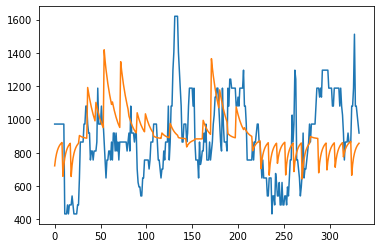

In [133]:
test_y = test_y.reshape(-1, 1)
test_y = ss.inverse_transform(test_y)
pred_y = pred_y.reshape(-1, 1)
pred_y = ss.inverse_transform(pred_y)

plt.plot(test_y, label="test")
plt.plot(pred_y, label="pred")